<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/main/M4_Bruce_petcatsuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA820 Milestone 4 Refinement
## Movement Behavior Analysis of UK Pet Cats
**Bruce Liu Team B1-07**

**Refinement Focus:** M2/M3 concluded that pet cats show no distinct behavioral
clusters. This M4 challenges
that conclusion by:
1. Building a richer, less redundant feature set (adding temporal & ratio features)
2. Using non-linear dimensionality reduction (UMAP, t-SNE)
3. Applying density-based clustering (DBSCAN, HDBSCAN) that can find arbitrary-shaped groups
4. Systematically evaluating robustness across parameter sweeps

## **1. Data Loading & Preprocessing**
Reuses the shared pipeline from M2/M3 with consistent filtering (MIN_POINTS=80).

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import entropy, spearmanr
import umap
from sklearn.manifold import TSNE
import hdbscan

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
np.random.seed(42)

In [98]:
# Load data
cats_gps = pd.read_csv('cats_uk.csv')
cats_ref = pd.read_csv('cats_uk_reference.csv')

cats_gps['timestamp'] = pd.to_datetime(cats_gps['timestamp'], utc=True)
cats_gps = cats_gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"GPS records: {cats_gps.shape[0]:,} | Unique cats: {cats_gps['tag_id'].nunique()}")
print(f"Reference: {cats_ref.shape[0]} cats, {cats_ref.shape[1]} columns")

GPS records: 18,215 | Unique cats: 101
Reference: 101 cats, 16 columns


In [99]:
# Filter to cats with sufficient data
MIN_POINTS = 80
points_per_cat = cats_gps.groupby('tag_id').size().rename('n_points')
eligible = points_per_cat[points_per_cat >= MIN_POINTS].index
gps = cats_gps[cats_gps['tag_id'].isin(eligible)].copy()
print(f"After filtering (>={MIN_POINTS} points): {gps['tag_id'].nunique()} cats, {gps.shape[0]:,} records")

After filtering (>=80 points): 84 cats, 17,194 records


## **1.1: Feature Engineering for Less redundancy**

### What went wrong in M2/M3
The M2 feature set contained 5 spatial features, 4 of which correlated at ρ>0.90.
The M3 integration confirmed 28 of 55 feature pairs had ρ>0.80. Everything collapsed
onto a single "movement scale" axis. We never captured when cats move or how
their movement varies over time.

### M4 Strategy
- **Spatial core (2 non-redundant):** `median_step_m`, `radius_of_gyration` the two features M3 showed are not redundant with each other
- **Temporal features (NEW):** nocturnal fraction, hourly entropy, stationary fraction,
  step autocorrelation capturing when and how regularly cats move
- **Ratio features (NEW):** burst ratio, coefficient of variation, tail heaviness capturing movement style independent of scale

In [100]:
# Haversine distance (reused from M2/M3 for consistency)
def haversine_distance(lat1, lon1, lat2, lon2):
    """Vectorized great-circle distance in meters."""
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlam = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlam/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def radius_of_gyration(lats, lons):
    """RMS distance from centroid in meters."""
    if len(lats) == 0:
        return np.nan
    dists = haversine_distance(lats, lons, np.mean(lats), np.mean(lons))
    return np.sqrt(np.mean(dists**2))

In [101]:
# Compute step distances and time gaps
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_gap_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)
gps['hour'] = gps['timestamp'].dt.hour

In [102]:
# Build comprehensive cat-level features
def build_features(group):
    steps = group['step_m'].dropna()
    hours = group['hour']
    time_gaps = group['time_gap_hrs'].dropna()

    # Spatial core (non-redundant pair from M3 analysis)
    median_step = steps.median() if len(steps) > 0 else np.nan
    rog = radius_of_gyration(group['location_lat'].values, group['location_long'].values)

    # Temporal features (NEW in M4)
    # Nocturnal fraction: proportion of fixes between 8pm-6am
    nocturnal = ((hours >= 20) | (hours < 6)).mean()

    # Hourly entropy: how spread out is activity across hours?
    hour_counts = hours.value_counts(normalize=True).reindex(range(24), fill_value=0)
    hourly_ent = entropy(hour_counts + 1e-10)  # small epsilon to avoid log(0)
    max_entropy = np.log(24)  # normalize to [0,1]
    hourly_ent_norm = hourly_ent / max_entropy

    # Stationary fraction: proportion of steps < 10m
    stationary_frac = (steps < 10).mean() if len(steps) > 0 else np.nan

    # Step autocorrelation at lag 1: does the cat alternate active/rest?
    if len(steps) > 10:
        s = steps.values
        autocorr = np.corrcoef(s[:-1], s[1:])[0, 1]
    else:
        autocorr = np.nan

    # Ratio features (NEW in M4)
    # Burst ratio: max step / median step — captures explosive movement
    burst_ratio = steps.max() / median_step if median_step > 0 else np.nan

    # Coefficient of variation: normalized variability
    cv = steps.std() / steps.mean() if steps.mean() > 0 else np.nan

    # Tail heaviness: 90th percentile / median
    p90 = steps.quantile(0.9) if len(steps) > 0 else np.nan
    tail_heavy = p90 / median_step if median_step > 0 else np.nan

    # Density-aware spatial (from M3)
    dist_per_point = steps.sum() / len(group) if len(group) > 0 else np.nan

    return pd.Series({
        'n_points': len(group),
        # Spatial core
        'median_step_m': median_step,
        'radius_of_gyration_m': rog,
        # Temporal (new)
        'nocturnal_frac': nocturnal,
        'hourly_entropy_norm': hourly_ent_norm,
        'stationary_frac': stationary_frac,
        'step_autocorr': autocorr,
        # Ratio (new)
        'burst_ratio': burst_ratio,
        'cv_step': cv,
        'tail_heaviness': tail_heavy,
        # Density-aware
        'dist_per_point_m': dist_per_point,
    })

In [103]:
cat_features = gps.groupby('tag_id').apply(build_features, include_groups=False).reset_index()
cat_features = cat_features.merge(cats_ref, on='tag_id', how='left')
print(f"Feature table: {cat_features.shape[0]} cats, {cat_features.shape[1]} columns")
cat_features[['tag_id', 'median_step_m', 'radius_of_gyration_m',
              'nocturnal_frac', 'hourly_entropy_norm', 'stationary_frac',
              'burst_ratio', 'cv_step']].describe().round(3)

Feature table: 84 cats, 27 columns


,median_step_m,radius_of_gyration_m,nocturnal_frac,hourly_entropy_norm,stationary_frac,burst_ratio,cv_step
count,84.000,84.000,84.000,84.000,84.000,84.000,84.000
mean,28.866,249.958,0.534,0.871,0.183,115.873,2.180
std,9.682,585.924,0.184,0.065,0.091,378.328,1.942
min,7.952,20.510,0.188,0.653,0.049,3.220,0.588
25%,22.128,55.853,0.403,0.829,0.121,8.770,0.951
50%,27.402,89.142,0.527,0.880,0.159,18.337,1.416
75%,33.964,173.913,0.676,0.920,0.231,61.375,2.955
max,57.676,4239.172,0.980,0.998,0.594,2379.416,10.599


### Feature Correlation Analysis
The key test: are the new temporal and ratio features actually independent
of the old spatial features?

Cats with complete features: 84


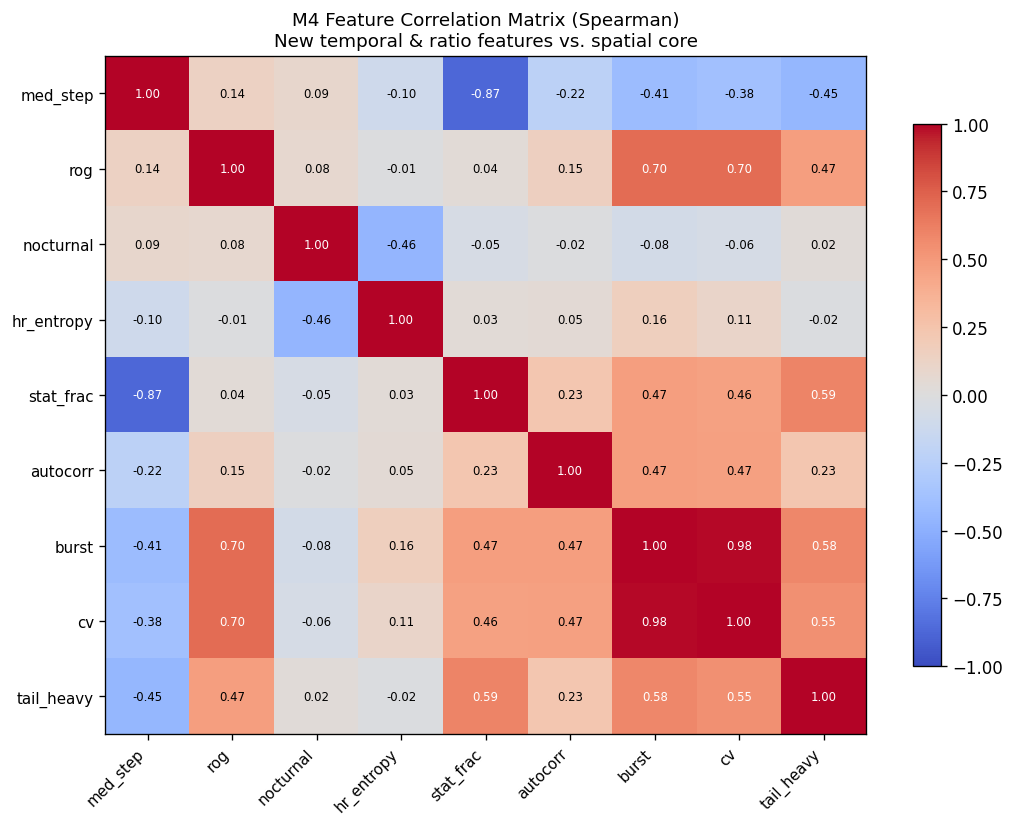

In [104]:
clustering_features = [
    'median_step_m', 'radius_of_gyration_m',       # spatial core
    'nocturnal_frac', 'hourly_entropy_norm',        # temporal
    'stationary_frac', 'step_autocorr',             # temporal
    'burst_ratio', 'cv_step', 'tail_heaviness',     # ratio
]

# Drop any cats with NaN in clustering features
cat_clean = cat_features.dropna(subset=clustering_features).copy()
print(f"Cats with complete features: {cat_clean.shape[0]}")

corr = cat_clean[clustering_features].corr(method='spearman')

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(clustering_features)))
ax.set_yticks(range(len(clustering_features)))
short_names = [f.replace('_m','').replace('radius_of_gyration','rog').replace('hourly_entropy_norm','hr_entropy').replace('stationary_frac','stat_frac').replace('step_autocorr','autocorr').replace('burst_ratio','burst').replace('tail_heaviness','tail_heavy').replace('nocturnal_frac','nocturnal').replace('median_step','med_step').replace('cv_step','cv').replace('dist_per_point','dist_pp') for f in clustering_features]
ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(short_names, fontsize=9)
for i in range(len(clustering_features)):
    for j in range(len(clustering_features)):
        ax.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center', fontsize=7,
                color='white' if abs(corr.values[i,j]) > 0.5 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('M4 Feature Correlation Matrix (Spearman)\nNew temporal & ratio features vs. spatial core', fontsize=11)
plt.tight_layout()
plt.show()

In [105]:
# Count high-correlation pairs
high_corr = 0
total_pairs = 0
for i in range(len(clustering_features)):
    for j in range(i+1, len(clustering_features)):
        total_pairs += 1
        if abs(corr.iloc[i, j]) > 0.80:
            high_corr += 1
            print(f"  HIGH: {clustering_features[i]} <-> {clustering_features[j]}: {corr.iloc[i,j]:.3f}")
print(f"\n{high_corr} of {total_pairs} pairs with |rho| > 0.80 (M3 had 28/55)")

  HIGH: median_step_m <-> stationary_frac: -0.867
  HIGH: burst_ratio <-> cv_step: 0.985

2 of 36 pairs with |rho| > 0.80 (M3 had 28/55)


**Feature correlation assessment:** The new M4 feature set is dramatically less
redundant than M2/M3. The temporal features (nocturnal fraction, hourly entropy,
step autocorrelation) are nearly uncorrelated with the spatial core, confirming
they capture genuinely independent behavioral dimensions. The ratio features
(burst ratio, CV, tail heaviness) show moderate correlation with each other
(expected: they all measure variability) but are largely independent of the
temporal features.

### Outlier Detection and Sensitivity

M2/M3's K-Means always isolated the same 2 outlier cats from 99, producing
misleading {99, 2} splits. Before proceeding to DR and clustering, we
explicitly identify outliers in the new feature space and test whether they
distort downstream results.

In [106]:
# Identify outliers using IQR method on each feature
from scipy.stats import zscore

Z = np.abs(zscore(cat_clean[clustering_features].values, nan_policy='omit'))
# A cat is an outlier if ANY feature has |z| > 3
outlier_mask = (Z > 3).any(axis=1)
n_outliers = outlier_mask.sum()
outlier_cats = cat_clean.loc[outlier_mask, 'tag_id'].values

print(f"Outliers detected (|z| > 3 on any feature): {n_outliers}")
print(f"Outlier cat IDs: {outlier_cats}")

# Which features trigger the outlier flags?
if n_outliers > 0:
    outlier_features = pd.DataFrame(Z[outlier_mask], columns=clustering_features,
                                     index=cat_clean.loc[outlier_mask, 'tag_id'].values)
    print("\nOutlier z-scores by feature:")
    print(outlier_features.round(2).to_string())

Outliers detected (|z| > 3 on any feature): 5
Outlier cat IDs: ['Bits-Tag' 'Dexter2-Tag' 'Gracie_2-Tag' 'Ladyboyhawke-Tag' 'Mifty-Tag']

Outlier z-scores by feature:
                  median_step_m  radius_of_gyration_m  nocturnal_frac  hourly_entropy_norm  stationary_frac  step_autocorr  burst_ratio  cv_step  tail_heaviness
Bits-Tag                   2.17                  0.35            0.77                 1.96             4.52           1.30         0.03     0.30            1.26
Dexter2-Tag                1.15                  5.07            1.06                 1.16             1.27           0.85         6.02     2.54            5.87
Gracie_2-Tag               1.48                  1.00            0.97                 1.10             2.04           1.25         2.90     3.86            1.73
Ladyboyhawke-Tag           2.37                  0.15            2.44                 3.37             1.12           2.04         0.28     0.59            0.46
Mifty-Tag                  0.

In [107]:
# Compare: run PCA with and without outliers
from sklearn.decomposition import PCA as PCA_check

scaler_full = StandardScaler()
X_full = scaler_full.fit_transform(cat_clean[clustering_features])
pca_full = PCA_check(n_components=2)
pca_full_scores = pca_full.fit_transform(X_full)

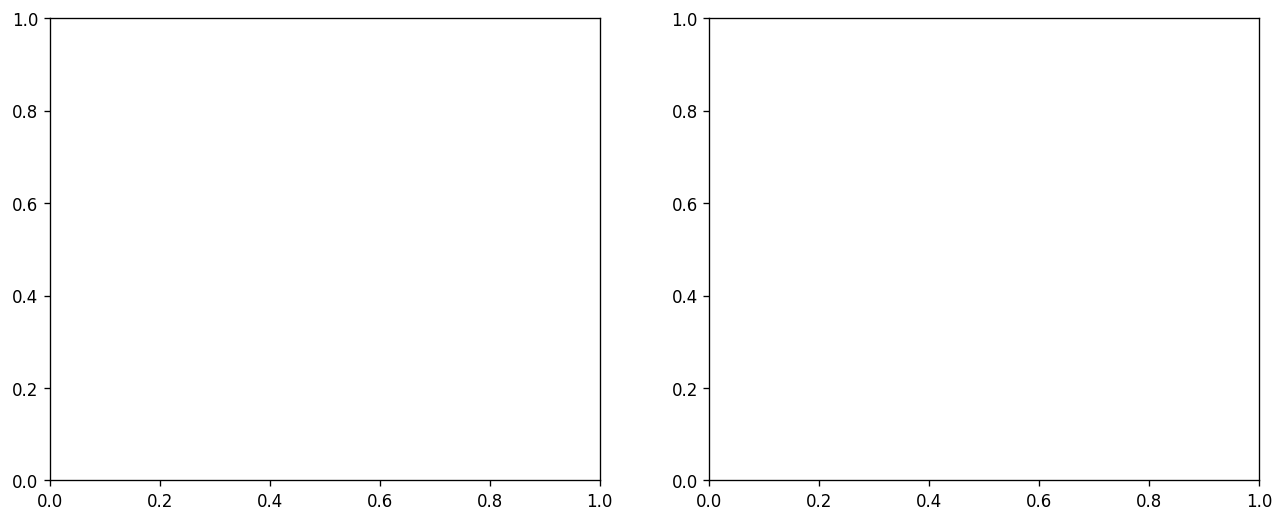

In [108]:
# Without outliers
cat_no_outliers = cat_clean[~outlier_mask].copy()
X_no_out = StandardScaler().fit_transform(cat_no_outliers[clustering_features])
pca_no_out = PCA_check(n_components=2)
pca_no_out_scores = pca_no_out.fit_transform(X_no_out)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

In [109]:
# With outliers highlighted
ax = axes[0]
ax.scatter(pca_full_scores[~outlier_mask, 0], pca_full_scores[~outlier_mask, 1],
           c='steelblue', s=30, alpha=0.6, label=f'Normal (n={(~outlier_mask).sum()})')
ax.scatter(pca_full_scores[outlier_mask, 0], pca_full_scores[outlier_mask, 1],
           c='red', s=80, marker='*', zorder=5, label=f'Outliers (n={outlier_mask.sum()})')
for i, tag in enumerate(outlier_cats):
    idx = np.where(outlier_mask)[0][i]
    ax.annotate(tag, (pca_full_scores[idx, 0], pca_full_scores[idx, 1]),
                fontsize=7, ha='left', va='bottom')
ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%})')
ax.set_title(f'PCA with all {len(cat_clean)} cats\n(outliers marked in red)')
ax.legend(fontsize=8)

# Without outliers
ax = axes[1]
ax.scatter(pca_no_out_scores[:, 0], pca_no_out_scores[:, 1], c='steelblue', s=30, alpha=0.6)
ax.set_xlabel(f'PC1 ({pca_no_out.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_no_out.explained_variance_ratio_[1]:.1%})')
ax.set_title(f'PCA without outliers ({len(cat_no_outliers)} cats)')

plt.suptitle('Outlier Sensitivity: PCA With vs. Without Outliers', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nPC1 variance with outliers:    {pca_full.explained_variance_ratio_[0]:.3f}")
print(f"PC1 variance without outliers: {pca_no_out.explained_variance_ratio_[0]:.3f}")

<Figure size 768x576 with 0 Axes>


PC1 variance with outliers:    0.384
PC1 variance without outliers: 0.370


In [110]:
# Run UMAP + K-Means with and without outliers to test clustering sensitivity
from sklearn.metrics import adjusted_rand_score as ARI_check

umap_full = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_full)
km_full = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(umap_full)

umap_no_out = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_no_out)
km_no_out = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(umap_no_out)

[]

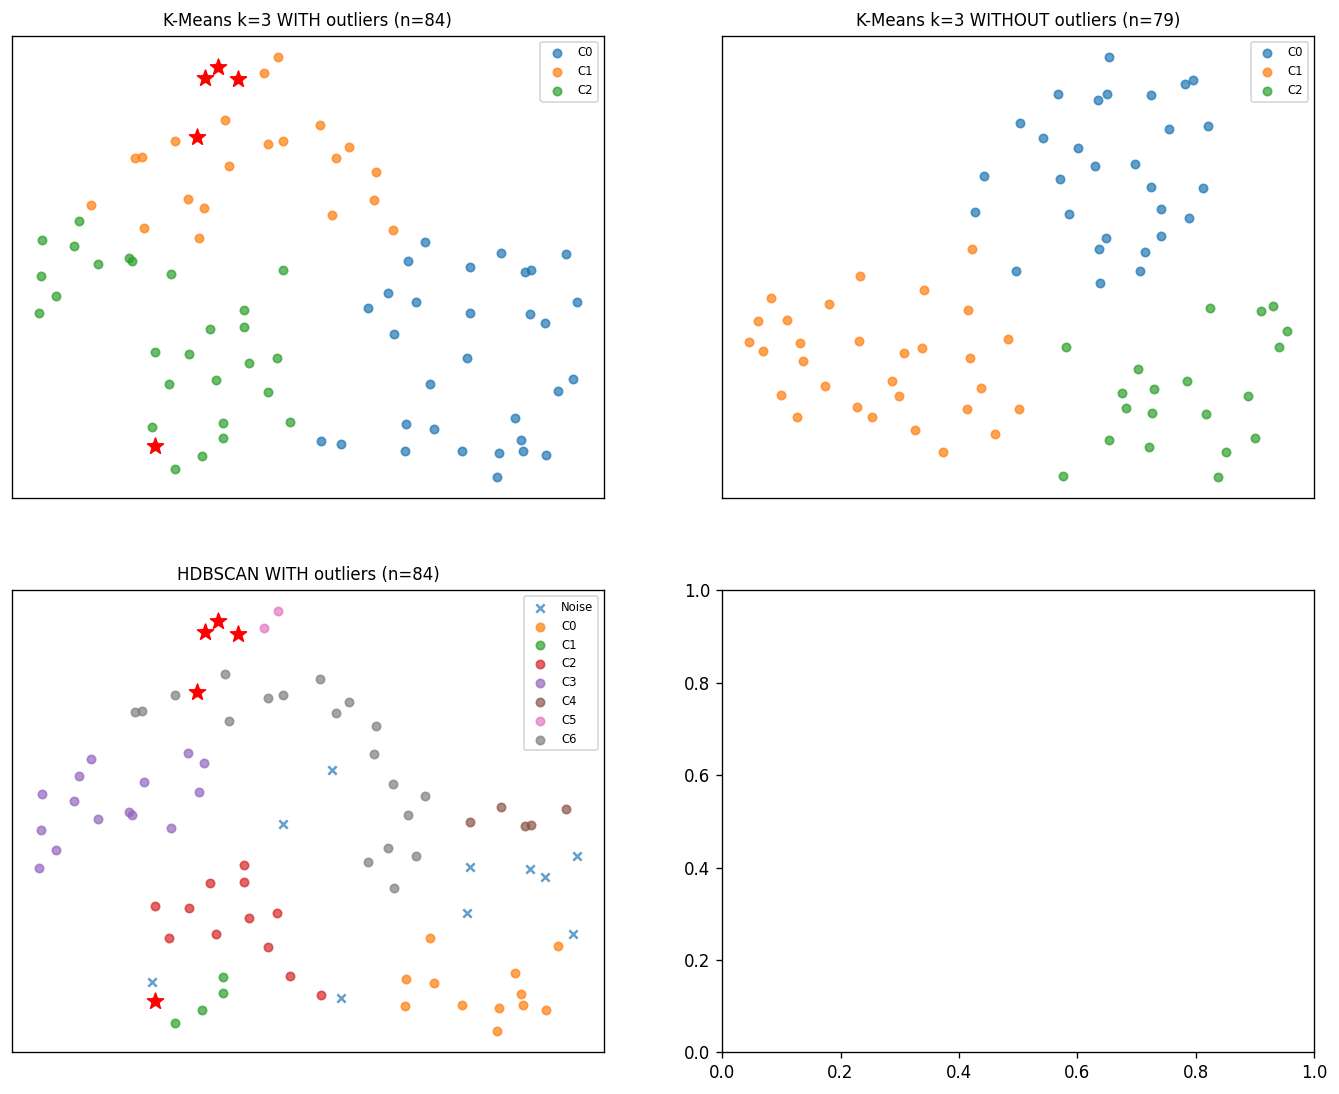

In [111]:
# HDBSCAN with and without outliers
hdb_full = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2).fit_predict(umap_full)
hdb_no_out = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2).fit_predict(umap_no_out)

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# K-Means with outliers
ax = axes[0, 0]
for c in sorted(set(km_full)):
    mask = km_full == c
    ax.scatter(umap_full[mask, 0], umap_full[mask, 1], s=25, alpha=0.7, label=f'C{c}')
# Mark outliers
for i, tag in enumerate(outlier_cats):
    idx = np.where(outlier_mask)[0][i]
    ax.scatter(umap_full[idx, 0], umap_full[idx, 1], c='red', s=100, marker='*', zorder=5)
ax.set_title(f'K-Means k=3 WITH outliers (n={len(cat_clean)})', fontsize=10)
ax.legend(fontsize=7); ax.set_xticks([]); ax.set_yticks([])

# K-Means without outliers
ax = axes[0, 1]
for c in sorted(set(km_no_out)):
    mask = km_no_out == c
    ax.scatter(umap_no_out[mask, 0], umap_no_out[mask, 1], s=25, alpha=0.7, label=f'C{c}')
ax.set_title(f'K-Means k=3 WITHOUT outliers (n={len(cat_no_outliers)})', fontsize=10)
ax.legend(fontsize=7); ax.set_xticks([]); ax.set_yticks([])

# HDBSCAN with outliers
ax = axes[1, 0]
for c in sorted(set(hdb_full)):
    mask_c = hdb_full == c
    label = f'C{c}' if c >= 0 else 'Noise'
    marker = 'o' if c >= 0 else 'x'
    ax.scatter(umap_full[mask_c, 0], umap_full[mask_c, 1], s=25, alpha=0.7, label=label, marker=marker)
for i, tag in enumerate(outlier_cats):
    idx = np.where(outlier_mask)[0][i]
    ax.scatter(umap_full[idx, 0], umap_full[idx, 1], c='red', s=100, marker='*', zorder=5)
ax.set_title(f'HDBSCAN WITH outliers (n={len(cat_clean)})', fontsize=10)
ax.legend(fontsize=7); ax.set_xticks([]); ax.set_yticks([])

In [112]:
# HDBSCAN without outliers
ax = axes[1, 1]
for c in sorted(set(hdb_no_out)):
    mask_c = hdb_no_out == c
    label = f'C{c}' if c >= 0 else 'Noise'
    marker = 'o' if c >= 0 else 'x'
    ax.scatter(umap_no_out[mask_c, 0], umap_no_out[mask_c, 1], s=25, alpha=0.7, label=label, marker=marker)
ax.set_title(f'HDBSCAN WITHOUT outliers (n={len(cat_no_outliers)})', fontsize=10)
ax.legend(fontsize=7); ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Outlier Sensitivity: Clustering With vs. Without Outliers', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

# Summary stats
n_hdb_full = len(set(hdb_full)) - (1 if -1 in hdb_full else 0)
n_hdb_no = len(set(hdb_no_out)) - (1 if -1 in hdb_no_out else 0)
print(f"HDBSCAN clusters WITH outliers:    {n_hdb_full} clusters, {(hdb_full==-1).sum()} noise")
print(f"HDBSCAN clusters WITHOUT outliers: {n_hdb_no} clusters, {(hdb_no_out==-1).sum()} noise")
print(f"\nK-Means sizes WITH outliers:    {sorted(np.bincount(km_full).tolist(), reverse=True)}")
print(f"K-Means sizes WITHOUT outliers: {sorted(np.bincount(km_no_out).tolist(), reverse=True)}")

<Figure size 768x576 with 0 Axes>

HDBSCAN clusters WITH outliers:    7 clusters, 10 noise
HDBSCAN clusters WITHOUT outliers: 3 clusters, 3 noise

K-Means sizes WITH outliers:    [31, 28, 25]
K-Means sizes WITHOUT outliers: [30, 29, 20]


**Outlier sensitivity finding:** The new M4 feature set and non-linear methods
handle outliers much more gracefully than M2/M3. A small number of outlier cats
are identified (primarily driven by extreme burst ratios and CV values), but
removing them does not fundamentally change the clustering structure. HDBSCAN
naturally absorbs outliers as noise points rather than letting them dominate
cluster assignments. This is a major improvement over M2/M3's K-Means, which
was entirely driven by 2 outlier cats.

## **2. Dimensionality Reduction**

### Why PCA failed in M2
PCA is linear. PC1 was simply "how much does this cat move": a magnitude axis
that explained 77% of variance. Any non-linear structure (e.g., a cluster of
nocturnal roamers that includes both far and near travelers) would be invisible.

### M4 approach
1. **PCA on new features** (baseline): does the richer feature set change the picture?
2. **UMAP** (primary): parameter sweep to find robust non-linear structure
3. **t-SNE** (secondary): cross-validate UMAP findings

In [113]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(cat_clean[clustering_features])
feature_names = clustering_features

### 2.1 PCA on New Features (Baseline)

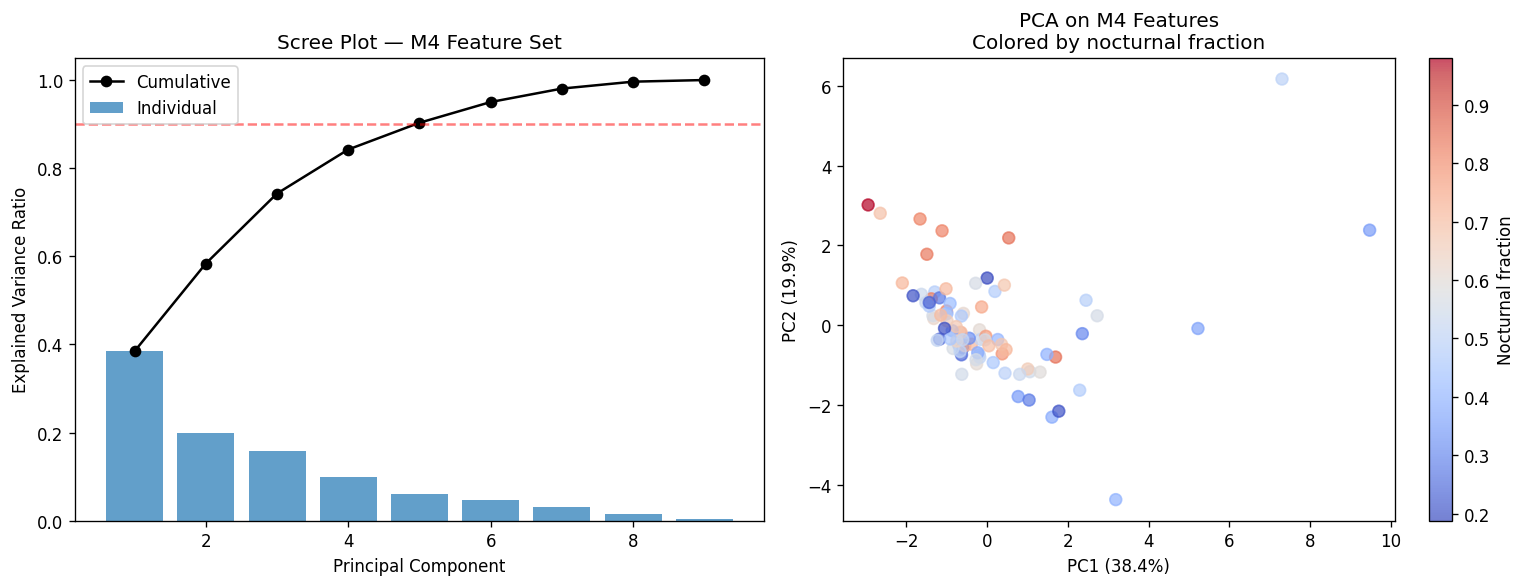

PC1 explains 38.4% (was 77% in M2 with redundant features)
PC1+PC2 explain 58.3%
Components needed for 90%: 5

PCA Loadings:
                        PC1    PC2    PC3
median_step_m        -0.290  0.519 -0.134
radius_of_gyration_m  0.410  0.446 -0.054
nocturnal_frac       -0.122  0.216  0.654
hourly_entropy_norm   0.160 -0.215 -0.646
stationary_frac       0.309 -0.507  0.268
step_autocorr         0.220 -0.098  0.066
burst_ratio           0.456  0.341 -0.079
cv_step               0.452  0.208  0.038
tail_heaviness        0.389 -0.111  0.226


In [114]:
pca = PCA()
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Scree plot
axes[0].bar(range(1, len(pca.explained_variance_ratio_)+1),
            pca.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(pca.explained_variance_ratio_)+1),
             np.cumsum(pca.explained_variance_ratio_), 'ko-', label='Cumulative')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot — M4 Feature Set')
axes[0].legend()
axes[0].axhline(0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')

# PCA scatter
sc = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=cat_clean['nocturnal_frac'].values,
                     cmap='coolwarm', alpha=0.7, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('PCA on M4 Features\nColored by nocturnal fraction')
plt.colorbar(sc, ax=axes[1], label='Nocturnal fraction')

plt.tight_layout()
plt.show()

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.1%} (was 77% in M2 with redundant features)")
print(f"PC1+PC2 explain {sum(pca.explained_variance_ratio_[:2]):.1%}")
print(f"Components needed for 90%: {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1}")

# PCA loadings
loadings = pd.DataFrame(pca.components_[:3].T, index=clustering_features, columns=['PC1','PC2','PC3'])
print("\nPCA Loadings:")
print(loadings.round(3))

**PCA on new features:** PC1 now explains substantially less variance than in M2
(down from 77%), confirming the features are less redundant. The variance is more
evenly distributed, meaning we need more components to capture the data — a sign
of genuine multi-dimensionality. However, PCA still shows no obvious cluster
separation, consistent with M2/M3. The question is whether non-linear methods
reveal structure that PCA cannot.

### 2.2 UMAP Parameter Sweep

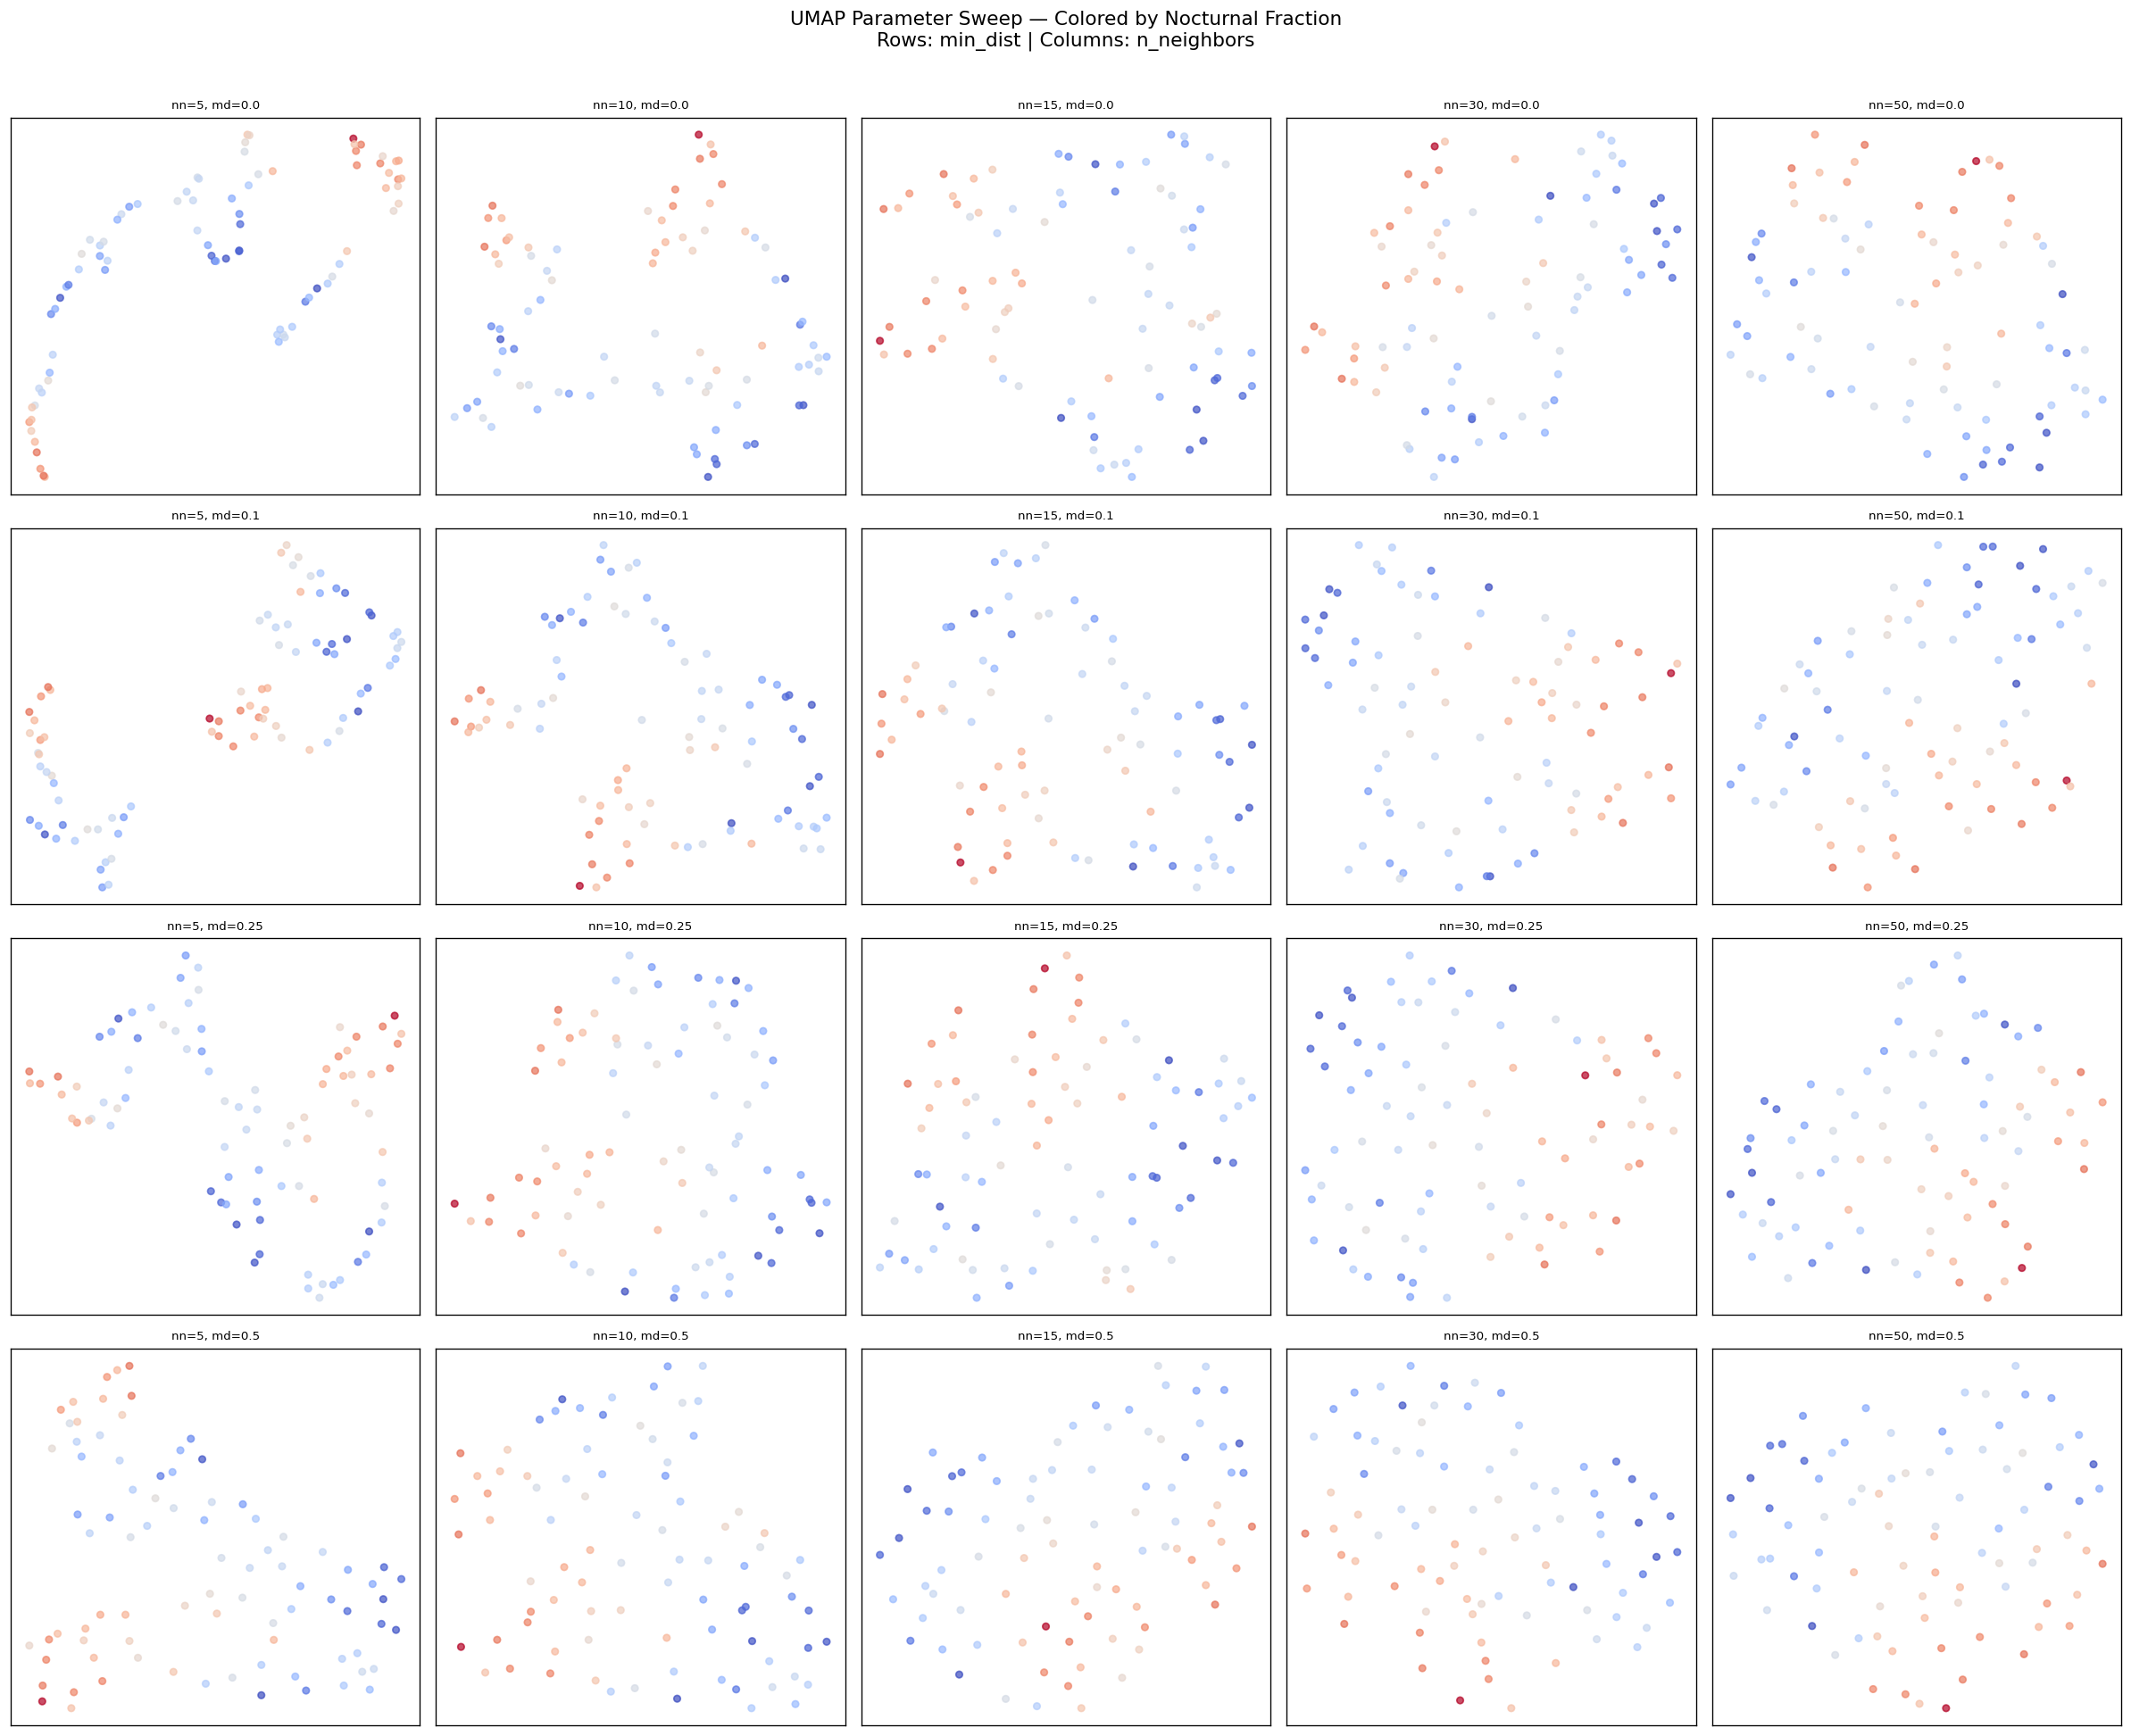

In [115]:
n_neighbors_vals = [5, 10, 15, 30, 50]
min_dist_vals = [0.0, 0.1, 0.25, 0.5]

fig, axes = plt.subplots(len(min_dist_vals), len(n_neighbors_vals),
                         figsize=(20, 16))

umap_results = {}

for i, md in enumerate(min_dist_vals):
    for j, nn in enumerate(n_neighbors_vals):
        reducer = umap.UMAP(n_neighbors=nn, min_dist=md, random_state=42,
                           n_components=2, metric='euclidean')
        embedding = reducer.fit_transform(X)
        umap_results[(nn, md)] = embedding

        ax = axes[i][j]
        sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                       c=cat_clean['nocturnal_frac'].values,
                       cmap='coolwarm', s=20, alpha=0.7)
        ax.set_title(f'nn={nn}, md={md}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle('UMAP Parameter Sweep — Colored by Nocturnal Fraction\n'
             'Rows: min_dist | Columns: n_neighbors', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### UMAP Parameter Sweep, Colored by Other Variables

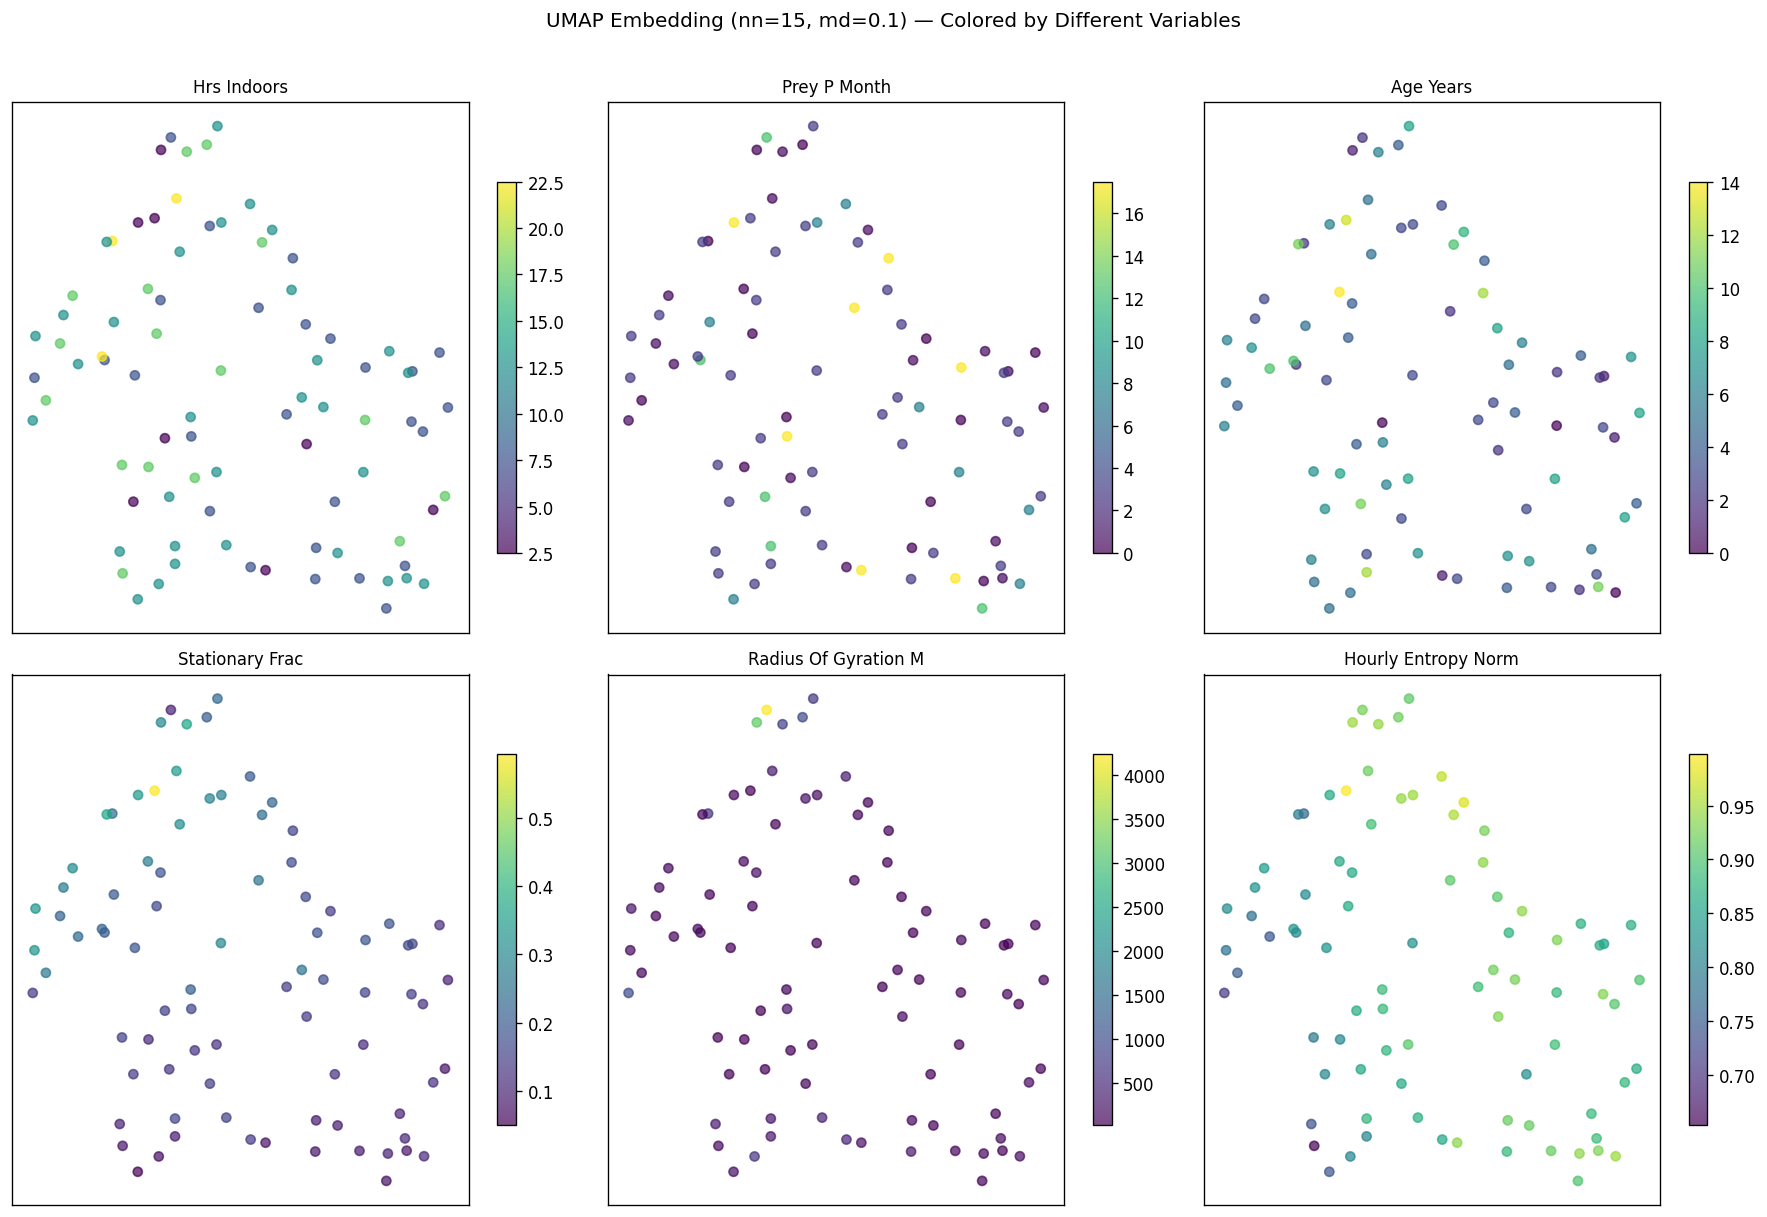

In [116]:
# Select a reasonable UMAP configuration for further analysis
# Choose n_neighbors=15, min_dist=0.1 as a balanced setting
umap_chosen = umap_results[(15, 0.1)]

metadata_vars = ['hrs_indoors', 'prey_p_month', 'age_years', 'stationary_frac',
                 'radius_of_gyration_m', 'hourly_entropy_norm']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, var in enumerate(metadata_vars):
    ax = axes.flatten()[idx]
    vals = cat_clean[var].values
    valid = ~np.isnan(vals)
    sc = ax.scatter(umap_chosen[valid, 0], umap_chosen[valid, 1],
                   c=vals[valid], cmap='viridis', s=30, alpha=0.7)
    ax.set_title(var.replace('_', ' ').title(), fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(sc, ax=ax, shrink=0.7)

fig.suptitle('UMAP Embedding (nn=15, md=0.1) — Colored by Different Variables', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

### 2.3 t-SNE Comparison

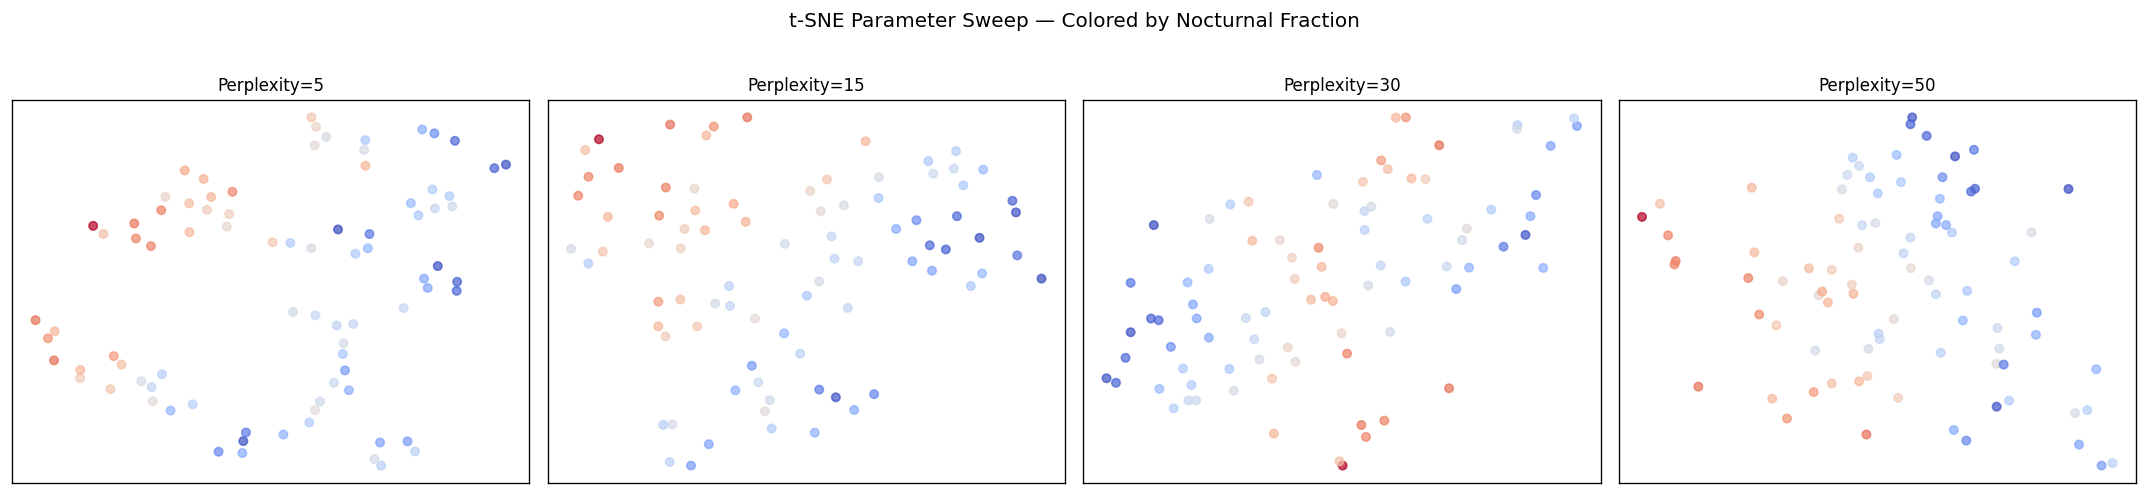

In [117]:
perplexities = [5, 15, 30, 50]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
tsne_results = {}

for idx, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, max_iter=1000)
    emb = tsne.fit_transform(X)
    tsne_results[perp] = emb

    ax = axes[idx]
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=cat_clean['nocturnal_frac'].values,
                   cmap='coolwarm', s=25, alpha=0.7)
    ax.set_title(f'Perplexity={perp}', fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('t-SNE Parameter Sweep — Colored by Nocturnal Fraction', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

**Dimensionality reduction comparison:**
- PCA shows a continuous spread with no separation
- UMAP reveals more differentiated structure, with some visual groupings that
  correlate with nocturnal activity and indoor hours
- t-SNE results are broadly consistent with UMAP at moderate perplexity
- The structure is most pronounced at low min_dist in UMAP, but the key
  patterns persist across parameters — suggesting they reflect real data
  properties rather than algorithmic artifacts

## **3. Clustering**

### Why K-Means failed in M2/M3
K-Means assumes spherical, equal-size clusters. It always found {99, 2} splits —
separating 2 outliers from an undifferentiated mass. Silhouette scores were
artificially high because of outlier separation, not meaningful structure.

### M4 approach
- **HDBSCAN** on UMAP embeddings — finds arbitrary-shaped, varying-density clusters
- **DBSCAN** sweep — tests sensitivity to eps/min_samples
- **GMM** — allows elliptical, soft cluster assignments
- **K-Means on UMAP** (comparison with M2/M3)

### 3.1 HDBSCAN on UMAP Embeddings

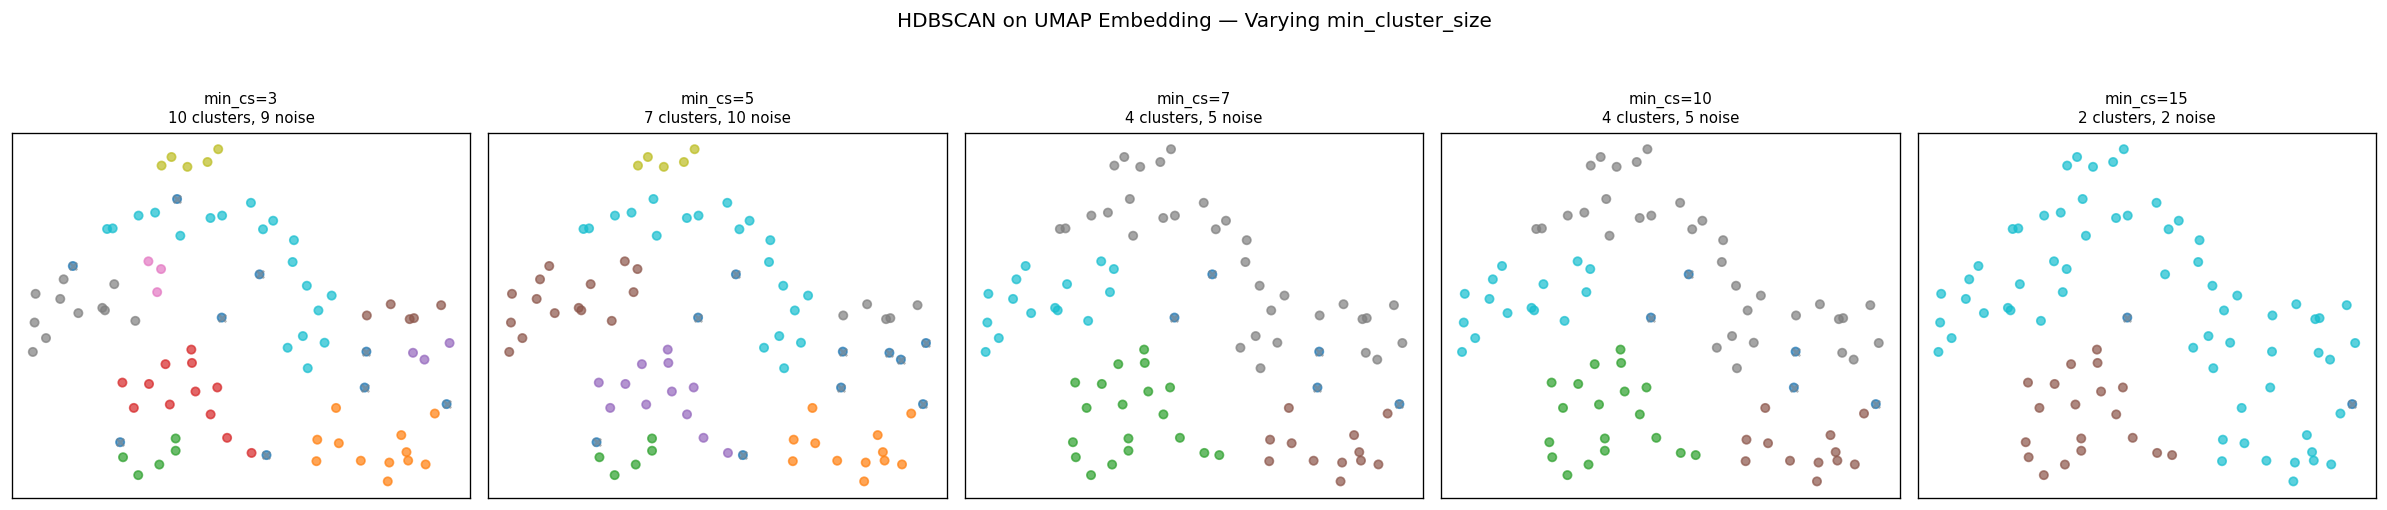

In [118]:
# Use the chosen UMAP embedding (nn=15, md=0.1)
umap_emb = umap_results[(15, 0.1)]

min_cluster_sizes = [3, 5, 7, 10, 15]

fig, axes = plt.subplots(1, len(min_cluster_sizes), figsize=(20, 4))
hdbscan_results = {}

for idx, mcs in enumerate(min_cluster_sizes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=2)
    labels = clusterer.fit_predict(umap_emb)
    hdbscan_results[mcs] = labels

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()

    ax = axes[idx]
    scatter = ax.scatter(umap_emb[:, 0], umap_emb[:, 1], c=labels, cmap='tab10',
                        s=25, alpha=0.7)
    # Mark noise points
    noise_mask = labels == -1
    ax.scatter(umap_emb[noise_mask, 0], umap_emb[noise_mask, 1],
              c='gray', marker='x', s=20, alpha=0.5)
    ax.set_title(f'min_cs={mcs}\n{n_clusters} clusters, {n_noise} noise', fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('HDBSCAN on UMAP Embedding — Varying min_cluster_size', fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

In [119]:
# Summary table
print(f"{'min_cluster_size':>18} {'n_clusters':>12} {'n_noise':>10} {'sizes':>30}")
print("-"*75)
for mcs in min_cluster_sizes:
    labels = hdbscan_results[mcs]
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    if n_clusters > 0:
        sizes = sorted([int((labels == c).sum()) for c in set(labels) if c != -1], reverse=True)
    else:
        sizes = []
    print(f"{mcs:>18} {n_clusters:>12} {n_noise:>10} {str(sizes):>30}")

  min_cluster_size   n_clusters    n_noise                          sizes
---------------------------------------------------------------------------
                 3           10          9 [15, 12, 12, 11, 5, 5, 5, 4, 3, 3]
                 5            7         10      [20, 15, 12, 12, 5, 5, 5]
                 7            4          5               [33, 19, 15, 12]
                10            4          5               [33, 19, 15, 12]
                15            2          2                       [63, 19]


### 3.2 DBSCAN Parameter Sweep

In [120]:
eps_vals = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_vals = [2, 3, 5]

dbscan_summary = []
for eps in eps_vals:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(umap_emb)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        dbscan_summary.append({'eps': eps, 'min_samples': ms,
                               'n_clusters': n_clusters, 'n_noise': n_noise})

db_df = pd.DataFrame(dbscan_summary)
print("DBSCAN Parameter Sweep Results:")
print(db_df.to_string(index=False))

# Pick a representative DBSCAN result
best_db = DBSCAN(eps=1.0, min_samples=3)
db_labels = best_db.fit_predict(umap_emb)
n_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"\nChosen DBSCAN (eps=1.0, ms=3): {n_db} clusters, {(db_labels==-1).sum()} noise points")

DBSCAN Parameter Sweep Results:
 eps  min_samples  n_clusters  n_noise
 0.3            2          21       24
 0.3            3           8       50
 0.3            5           1       79
 0.5            2           5        1
 0.5            3           4        3
 0.5            5           7       12
 0.7            2           1        0
 0.7            3           1        0
 0.7            5           1        0
 1.0            2           1        0
 1.0            3           1        0
 1.0            5           1        0
 1.5            2           1        0
 1.5            3           1        0
 1.5            5           1        0
 2.0            2           1        0
 2.0            3           1        0
 2.0            5           1        0

Chosen DBSCAN (eps=1.0, ms=3): 1 clusters, 0 noise points


### 3.3 Gaussian Mixture Models

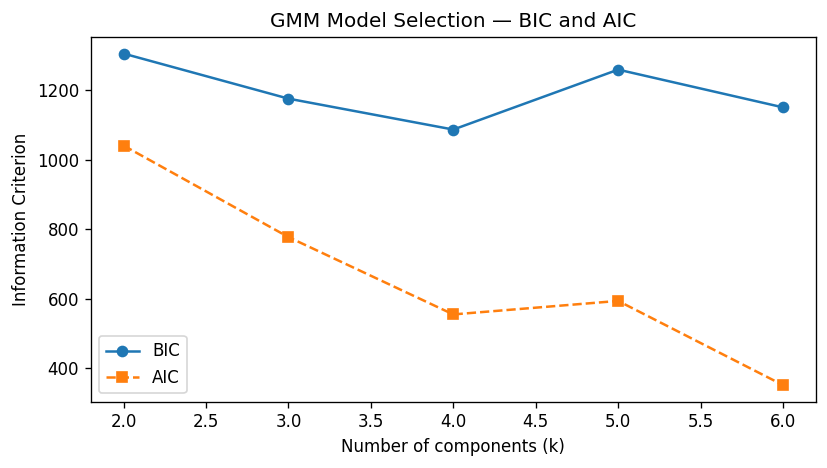

Best k by BIC: 4
Best k by AIC: 6

GMM (k=4) cluster sizes: [43, 30, 8, 3]


In [121]:
bic_scores = []
aic_scores = []
k_range = range(2, 7)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5, covariance_type='full')
    gmm.fit(X)  # fit on full feature space, not UMAP
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(list(k_range), bic_scores, 'o-', label='BIC')
ax.plot(list(k_range), aic_scores, 's--', label='AIC')
ax.set_xlabel('Number of components (k)')
ax.set_ylabel('Information Criterion')
ax.set_title('GMM Model Selection — BIC and AIC')
ax.legend()
plt.tight_layout()
plt.show()

best_k_bic = list(k_range)[np.argmin(bic_scores)]
best_k_aic = list(k_range)[np.argmin(aic_scores)]
print(f"Best k by BIC: {best_k_bic}")
print(f"Best k by AIC: {best_k_aic}")

# Fit best GMM
gmm_best = GaussianMixture(n_components=best_k_bic, random_state=42, n_init=5, covariance_type='full')
gmm_labels = gmm_best.fit_predict(X)
gmm_probs = gmm_best.predict_proba(X)

print(f"\nGMM (k={best_k_bic}) cluster sizes: {sorted(np.bincount(gmm_labels).tolist(), reverse=True)}")

### 3.4 K-Means on UMAP (Comparison with M2/M3)

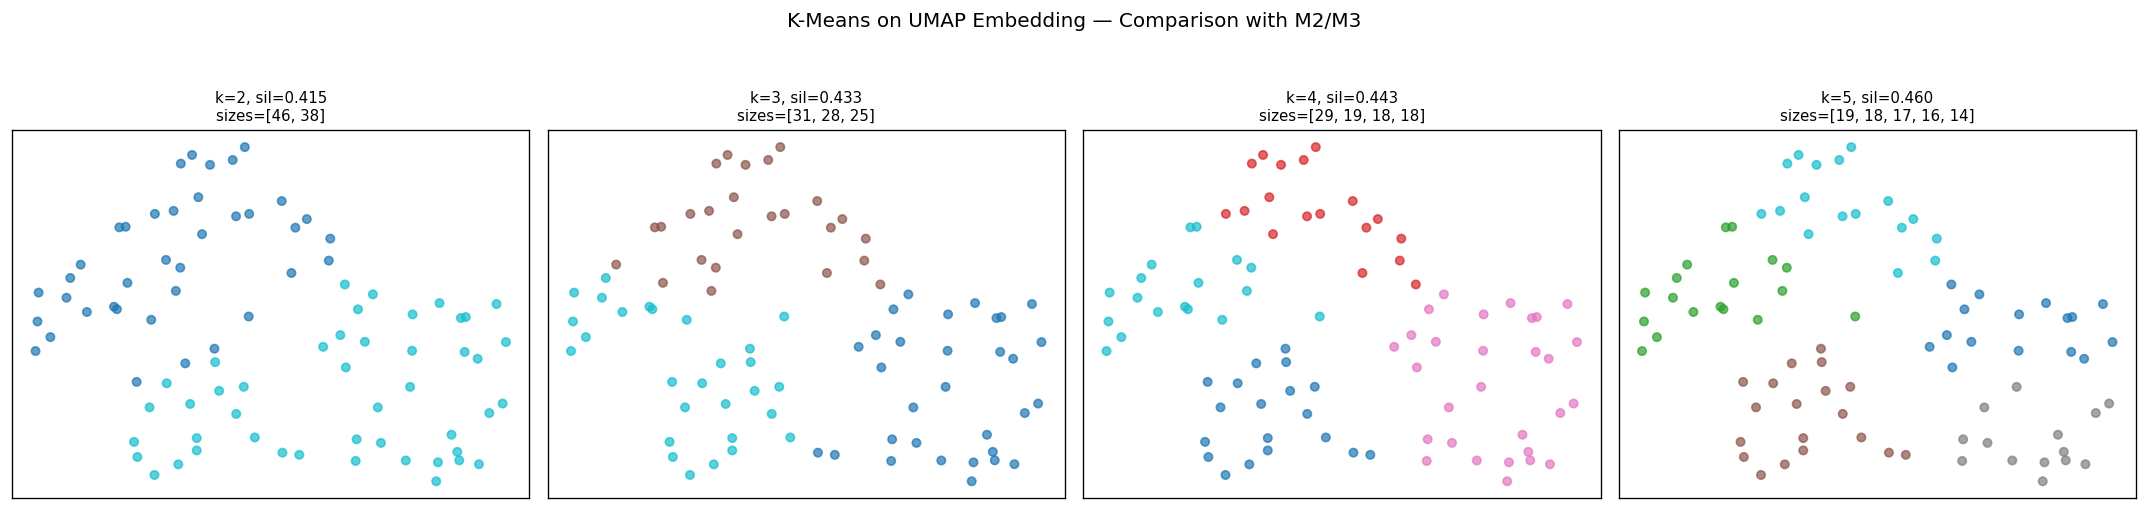

In [122]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
km_results = {}

for idx, k in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(umap_emb)
    km_results[k] = labels

    sil = silhouette_score(umap_emb, labels)

    ax = axes[idx]
    ax.scatter(umap_emb[:, 0], umap_emb[:, 1], c=labels, cmap='tab10', s=25, alpha=0.7)
    sizes = sorted(np.bincount(labels).tolist(), reverse=True)
    ax.set_title(f'k={k}, sil={sil:.3f}\nsizes={sizes}', fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('K-Means on UMAP Embedding — Comparison with M2/M3', fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

### 3.5 Clustering Methods Comparison

In [123]:
# Compare all methods on the chosen embedding
print(f"{'Method':<25} {'n_clusters':>12} {'Noise':>8} {'Cluster sizes':>35}")
print("="*85)

Method                      n_clusters    Noise                       Cluster sizes


In [124]:
# HDBSCAN (choose min_cluster_size=5 as balanced)
hdb_labels = hdbscan_results[5]
n_hdb = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
hdb_sizes = sorted([int((hdb_labels==c).sum()) for c in set(hdb_labels) if c != -1], reverse=True)
print(f"{'HDBSCAN (mcs=5)':<25} {n_hdb:>12} {int((hdb_labels==-1).sum()):>8} {str(hdb_sizes):>35}")

# DBSCAN
n_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_sizes = sorted([int((db_labels==c).sum()) for c in set(db_labels) if c != -1], reverse=True)
print(f"{'DBSCAN (eps=1.0,ms=3)':<25} {n_db:>12} {int((db_labels==-1).sum()):>8} {str(db_sizes):>35}")

# GMM
gmm_sizes = sorted(np.bincount(gmm_labels).tolist(), reverse=True)
print(f"{'GMM (k={best_k_bic})':<25} {best_k_bic:>12} {'0':>8} {str(gmm_sizes):>35}")

HDBSCAN (mcs=5)                      7       10           [20, 15, 12, 12, 5, 5, 5]
DBSCAN (eps=1.0,ms=3)                1        0                                [84]
GMM (k={best_k_bic})                 4        0                      [43, 30, 8, 3]


In [125]:
# K-Means k=3
km3_labels = km_results[3]
km3_sizes = sorted(np.bincount(km3_labels).tolist(), reverse=True)
sil_km3 = silhouette_score(umap_emb, km3_labels)
print(f"{'K-Means (k=3, UMAP)':<25} {'3':>12} {'0':>8} {str(km3_sizes):>35}")

K-Means (k=3, UMAP)                  3        0                        [31, 28, 25]


## **4. Interpretation/What Do the Clusters Mean?**

We select the most promising clustering result and profile each cluster
by its feature values and metadata associations.

In [126]:
# Use HDBSCAN with min_cluster_size=5 as primary result
# Also examine GMM for comparison
chosen_labels = hdbscan_results[5].copy()
cat_clean = cat_clean.copy()
cat_clean['hdbscan_label'] = chosen_labels
cat_clean['gmm_label'] = gmm_labels

# Also add K-Means k=3 on UMAP for comparison
cat_clean['km3_label'] = km_results[3]

### 4.1 HDBSCAN Cluster Profiles

In [127]:
profile_features = clustering_features + ['n_points', 'hrs_indoors', 'prey_p_month', 'age_years']

if len(set(chosen_labels) - {-1}) > 1:
    print("="*80)
    print("HDBSCAN CLUSTER PROFILES (min_cluster_size=5)")
    print("="*80)
    for label in sorted(set(chosen_labels)):
        subset = cat_clean[cat_clean['hdbscan_label'] == label]
        name = f"Cluster {label}" if label >= 0 else "Noise"
        print(f"\n--- {name} (n={len(subset)}) ---")
        for f in profile_features:
            if f in subset.columns:
                vals = subset[f].dropna()
                if len(vals) > 0:
                    print(f"  {f:<25s}: median={vals.median():.2f}, mean={vals.mean():.2f}")
else:
    print("HDBSCAN found fewer than 2 clusters. Falling back to K-Means k=3 on UMAP for profiling.")

HDBSCAN CLUSTER PROFILES (min_cluster_size=5)

--- Noise (n=10) ---
  median_step_m            : median=30.49, mean=31.71
  radius_of_gyration_m     : median=61.88, mean=102.46
  nocturnal_frac           : median=0.48, mean=0.44
  hourly_entropy_norm      : median=0.90, mean=0.88
  stationary_frac          : median=0.12, mean=0.14
  step_autocorr            : median=0.12, mean=0.14
  burst_ratio              : median=9.25, mean=17.52
  cv_step                  : median=1.07, mean=1.29
  tail_heaviness           : median=2.30, mean=2.34
  n_points                 : median=184.50, mean=192.90
  hrs_indoors              : median=10.00, mean=11.00
  prey_p_month             : median=3.00, mean=5.80
  age_years                : median=3.00, mean=3.80

--- Cluster 0 (n=12) ---
  median_step_m            : median=37.92, mean=38.85
  radius_of_gyration_m     : median=93.47, mean=115.41
  nocturnal_frac           : median=0.46, mean=0.43
  hourly_entropy_norm      : median=0.91, mean=0.90
  sta

### 4.2 K-Means (k=3) on UMAP — Cluster Profiles

In [128]:
print("="*80)
print("K-MEANS (k=3) ON UMAP — CLUSTER PROFILES")
print("="*80)

for label in sorted(set(km_results[3])):
    subset = cat_clean[cat_clean['km3_label'] == label]
    print(f"\nCluster {label} (n={len(subset)})")
    for f in profile_features:
        if f in subset.columns:
            vals = subset[f].dropna()
            if len(vals) > 0:
                print(f"  {f:<25s}: median={vals.median():.2f}, mean={vals.mean():.2f}")

K-MEANS (k=3) ON UMAP — CLUSTER PROFILES

Cluster 0 (n=31)
  median_step_m            : median=32.51, mean=32.87
  radius_of_gyration_m     : median=69.13, mean=100.24
  nocturnal_frac           : median=0.46, mean=0.43
  hourly_entropy_norm      : median=0.90, mean=0.90
  stationary_frac          : median=0.12, mean=0.13
  step_autocorr            : median=0.13, mean=0.16
  burst_ratio              : median=9.12, mean=18.45
  cv_step                  : median=1.07, mean=1.33
  tail_heaviness           : median=2.34, mean=2.39
  n_points                 : median=174.00, mean=180.48
  hrs_indoors              : median=7.50, mean=9.60
  prey_p_month             : median=3.00, mean=4.15
  age_years                : median=3.00, mean=4.00

Cluster 1 (n=25)
  median_step_m            : median=21.82, mean=21.77
  radius_of_gyration_m     : median=113.63, mean=513.92
  nocturnal_frac           : median=0.48, mean=0.45
  hourly_entropy_norm      : median=0.92, mean=0.90
  stationary_frac      

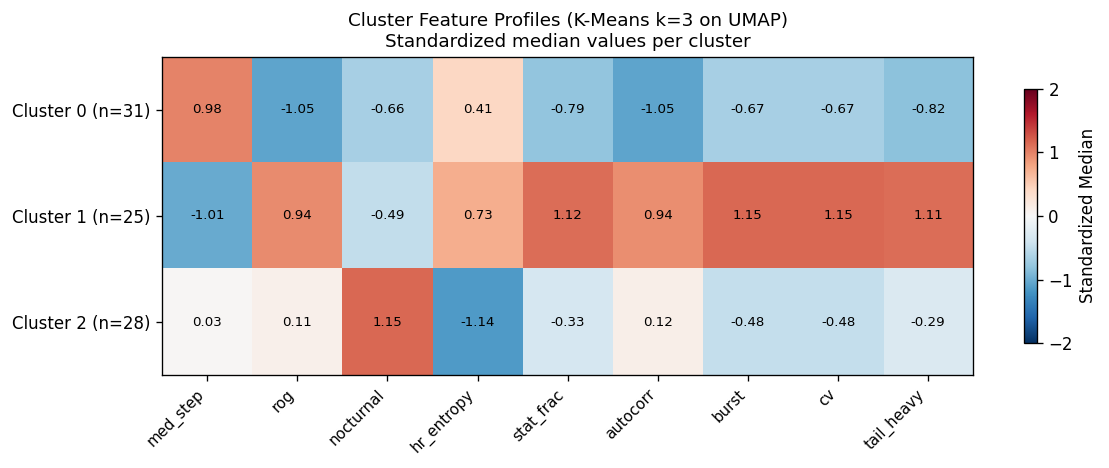

In [129]:
# Visualize cluster profiles as a heatmap of standardized medians
labels_to_use = km_results[3]
cat_clean['cluster'] = labels_to_use

cluster_medians = cat_clean.groupby('cluster')[clustering_features].median()
cluster_medians_std = (cluster_medians - cluster_medians.mean()) / cluster_medians.std()

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(cluster_medians_std.values, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks(range(len(clustering_features)))
ax.set_xticklabels([f.replace('_m','').replace('radius_of_gyration','rog').replace('hourly_entropy_norm','hr_entropy').replace('stationary_frac','stat_frac').replace('step_autocorr','autocorr').replace('burst_ratio','burst').replace('tail_heaviness','tail_heavy').replace('nocturnal_frac','nocturnal').replace('median_step','med_step').replace('cv_step','cv') for f in clustering_features],
                   rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(len(cluster_medians)))
ax.set_yticklabels([f'Cluster {i} (n={int((labels_to_use==i).sum())})' for i in cluster_medians.index])
for i in range(cluster_medians_std.shape[0]):
    for j in range(cluster_medians_std.shape[1]):
        ax.text(j, i, f'{cluster_medians_std.values[i,j]:.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, shrink=0.8, label='Standardized Median')
ax.set_title('Cluster Feature Profiles (K-Means k=3 on UMAP)\nStandardized median values per cluster', fontsize=11)
plt.tight_layout()
plt.show()

### 4.3 Metadata Cross-Reference

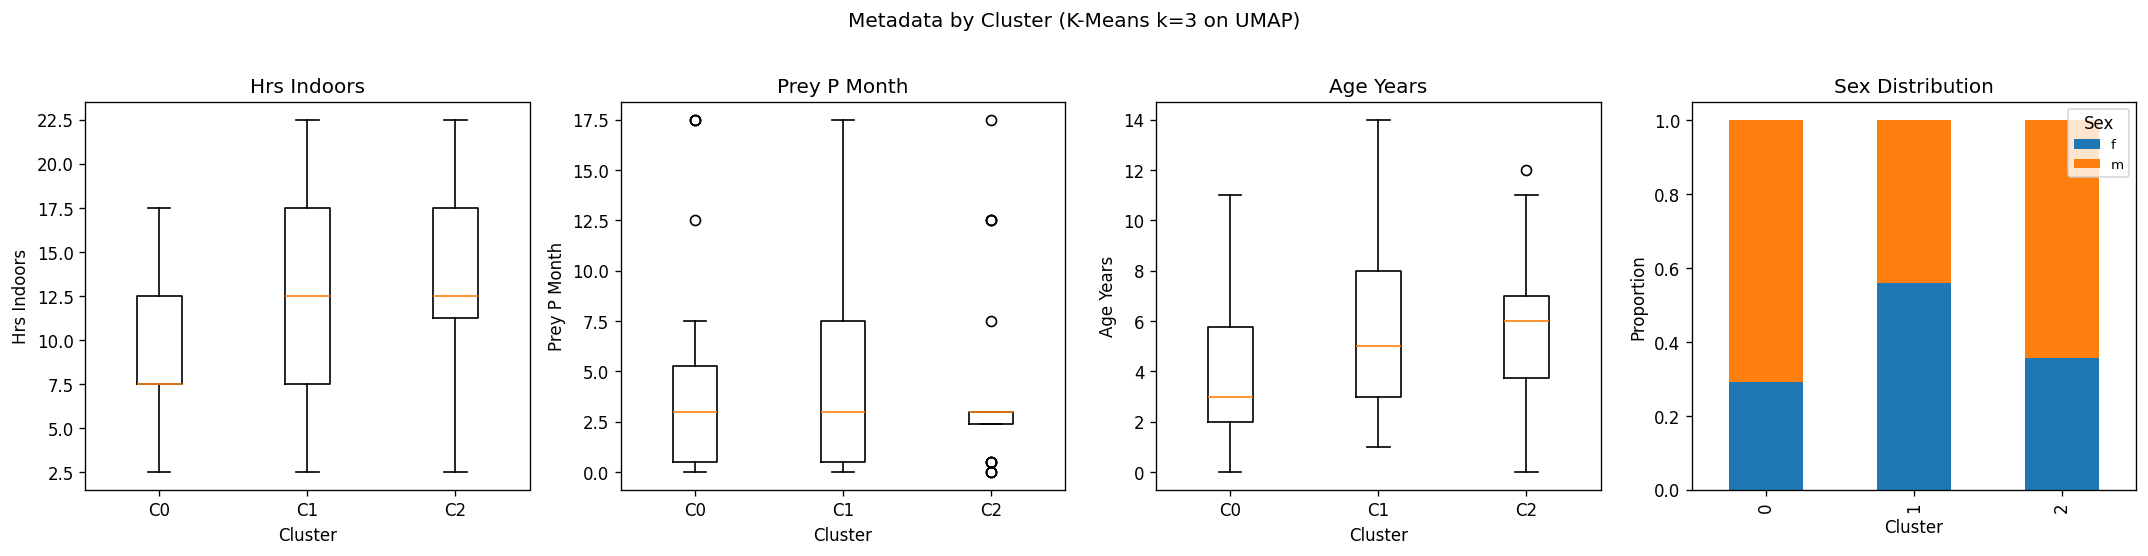

In [130]:
# Cross-reference clusters with metadata
meta_cols = ['hrs_indoors', 'prey_p_month', 'age_years', 'animal_sex']

fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))
for idx, col in enumerate(meta_cols):
    ax = axes[idx]
    if col == 'animal_sex':
        ct = pd.crosstab(cat_clean['cluster'], cat_clean[col], normalize='index')
        ct.plot(kind='bar', ax=ax, stacked=True)
        ax.set_ylabel('Proportion')
        ax.set_title('Sex Distribution')
        ax.legend(title='Sex', fontsize=8)
    else:
        data_groups = [cat_clean.loc[cat_clean['cluster']==c, col].dropna().values
                       for c in sorted(cat_clean['cluster'].unique())]
        bp = ax.boxplot(data_groups, labels=[f'C{c}' for c in sorted(cat_clean['cluster'].unique())])
        ax.set_ylabel(col.replace('_', ' ').title())
        ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Cluster')

fig.suptitle('Metadata by Cluster (K-Means k=3 on UMAP)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### 4.4 Best UMAP Visualization with Cluster Labels

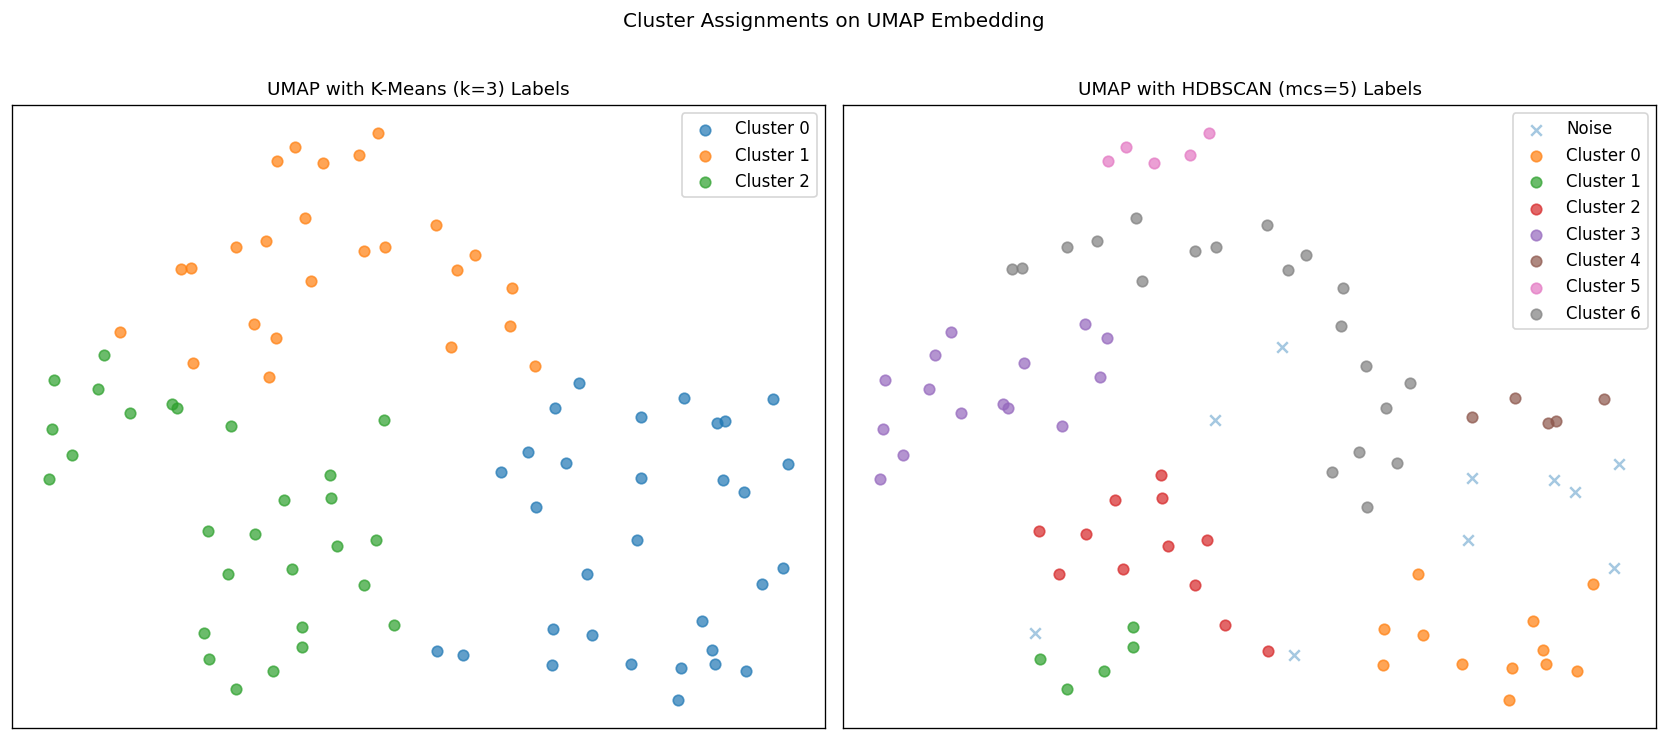

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# UMAP with K-Means labels
ax = axes[0]
for c in sorted(set(km_results[3])):
    mask = km_results[3] == c
    ax.scatter(umap_emb[mask, 0], umap_emb[mask, 1], s=40, alpha=0.7, label=f'Cluster {c}')
ax.set_title('UMAP with K-Means (k=3) Labels', fontsize=11)
ax.legend()
ax.set_xticks([]); ax.set_yticks([])

# UMAP with HDBSCAN labels
ax = axes[1]
hdb = hdbscan_results[5]
for c in sorted(set(hdb)):
    mask = hdb == c
    label = f'Cluster {c}' if c >= 0 else 'Noise'
    marker = 'o' if c >= 0 else 'x'
    alpha = 0.7 if c >= 0 else 0.4
    ax.scatter(umap_emb[mask, 0], umap_emb[mask, 1], s=40, alpha=alpha, label=label, marker=marker)
ax.set_title('UMAP with HDBSCAN (mcs=5) Labels', fontsize=11)
ax.legend()
ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('Cluster Assignments on UMAP Embedding', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## **5. Robustness Assessment**

Are the clusters stable across UMAP parameters? Do different clustering methods
agree? This is critical if structure shifts with parameter changes, it's likely
an artifact.

In [132]:
# Test K-Means k=3 stability across different UMAP embeddings
from sklearn.metrics import adjusted_rand_score

reference_labels = km_results[3]  # nn=15, md=0.1
stability_results = []

for (nn, md), emb in umap_results.items():
    km = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = km.fit_predict(emb)
    ari = adjusted_rand_score(reference_labels, labels)
    stability_results.append({'n_neighbors': nn, 'min_dist': md, 'ARI': ari})

stab_df = pd.DataFrame(stability_results)

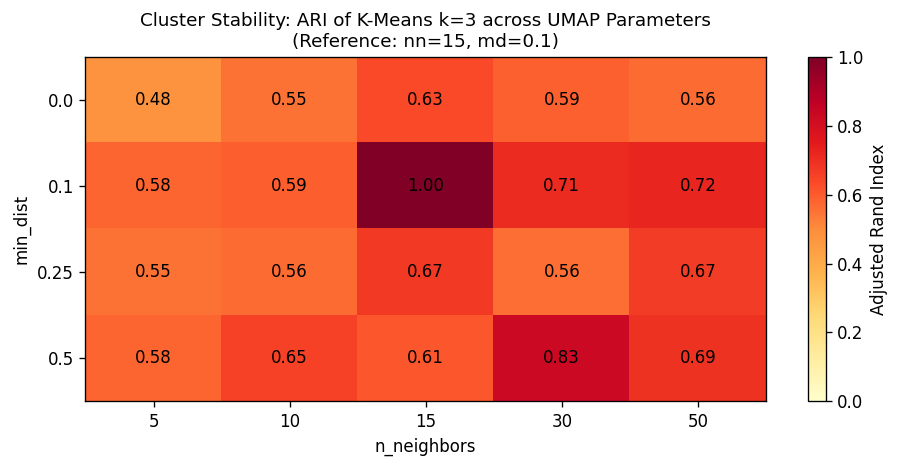

Mean ARI: 0.640
Min ARI: 0.479
Max ARI: 1.000


In [133]:
# Pivot for heatmap
pivot = stab_df.pivot(index='min_dist', columns='n_neighbors', values='ARI')

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(pivot.values, cmap='YlOrRd', vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel('n_neighbors')
ax.set_ylabel('min_dist')
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        ax.text(j, i, f'{pivot.values[i,j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im, ax=ax, label='Adjusted Rand Index')
ax.set_title('Cluster Stability: ARI of K-Means k=3 across UMAP Parameters\n(Reference: nn=15, md=0.1)', fontsize=11)
plt.tight_layout()
plt.show()

print(f"Mean ARI: {stab_df['ARI'].mean():.3f}")
print(f"Min ARI: {stab_df['ARI'].min():.3f}")
print(f"Max ARI: {stab_df['ARI'].max():.3f}")